In [13]:
# Section 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
import os
import json
import re
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
from pyswarms.single import GlobalBestPSO
from ucimlrepo import fetch_ucirepo
from dotenv import load_dotenv
from openai import OpenAI

# Silence convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load API Key
load_dotenv("OPENAI_API_KEY.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Load and preprocess dataset
dataset = fetch_ucirepo(id=69)  # Gene splicing dataset
X_raw = dataset.data.features
y_raw = dataset.data.targets
X = OrdinalEncoder().fit_transform(X_raw)
y = LabelEncoder().fit_transform(y_raw.values.ravel())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define search space
activation_options = ['identity', 'logistic', 'tanh', 'relu']
solver_options = ['lbfgs', 'sgd', 'adam']
lb = [5, 1e-4, 1e-6, 0, 0]
ub = [200, 1.0, 1.0, 3, 2]
bounds = (np.array(lb), np.array(ub))

# Section 2: GPT helper

def extract_json_list(text):
    match = re.search(r'\[.*\]', text, re.DOTALL)
    if match:
        return json.loads(match.group())
    raise ValueError("No valid JSON list found")

def query_gpt_for_particles(history, num_particles=3):
    prompt = f"""
You are optimizing MLP hyperparameters.
Here are past top configurations:
{history}

Now return ONLY a JSON list with {num_particles} new configurations like:
[{{"hidden": int, "lr": float, "alpha": float, "activation": int, "solver": int}}]

Only output the list. Do not add any explanation.
"""
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )
    print("=== GPT Prompt ===", prompt)
    print("=== GPT Response ===", response.choices[0].message.content)
    return extract_json_list(response.choices[0].message.content)
# Section 3: Baseline PSO objective
accuracy_history = []
best_so_far_history = []

def objective_mlp(swarm):
    global accuracy_history, best_so_far_history
    results = []
    for params in swarm:
        try:
            hidden_layer_sizes = (int(round(params[0])),)
            learning_rate_init = float(params[1])
            alpha = float(params[2])
            activation = activation_options[int(round(params[3]))]
            solver = solver_options[int(round(params[4]))]
            model = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                learning_rate_init=learning_rate_init,
                alpha=alpha,
                activation=activation,
                solver=solver,
                max_iter=500,
                random_state=42
            )
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            results.append(-acc)
        except:
            results.append(1.0)

    best_acc = -min(results)
    accuracy_history.append(best_acc)
    best_so_far_history.append(max(best_acc, best_so_far_history[-1]) if best_so_far_history else best_acc)
    return np.array(results)

# Section 4: LLM-enhanced PSO objective
llm_accuracy_history = []
llm_best_so_far_history = []

def objective_mlp_with_llm(swarm):
    global llm_accuracy_history, llm_best_so_far_history
    results = []
    for params in swarm:
        try:
            hidden_layer_sizes = (int(round(params[0])),)
            learning_rate_init = float(params[1])
            alpha = float(params[2])
            activation = activation_options[int(round(params[3]))]
            solver = solver_options[int(round(params[4]))]
            model = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                learning_rate_init=learning_rate_init,
                alpha=alpha,
                activation=activation,
                solver=solver,
                max_iter=500,
                random_state=42
            )
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            results.append(-acc)
        except:
            results.append(1.0)

    if len(llm_accuracy_history) % 5 == 0 and len(llm_accuracy_history) > 0:
        best_indices = np.argsort(results)[:3]
        history = [f"{list(swarm[i])} => {-results[i]:.4f}" for i in best_indices]
        new_particles = query_gpt_for_particles(history, num_particles=3)
        for i, new_p in zip(best_indices, new_particles):
            swarm[i] = [
                new_p['hidden'], new_p['lr'], new_p['alpha'], new_p['activation'], new_p['solver']
            ]

    best_acc = -min(results)
    llm_accuracy_history.append(best_acc)
    llm_best_so_far_history.append(max(best_acc, llm_best_so_far_history[-1]) if llm_best_so_far_history else best_acc)
    return np.array(results)


In [15]:
# Section 3: Baseline PSO objective
accuracy_history = []
best_so_far_history = []

def objective_mlp(swarm):
    global accuracy_history, best_so_far_history
    results = []
    for params in swarm:
        try:
            hidden_layer_sizes = (int(round(params[0])),)
            learning_rate_init = float(params[1])
            alpha = float(params[2])
            activation = activation_options[int(round(params[3]))]
            solver = solver_options[int(round(params[4]))]
            model = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                learning_rate_init=learning_rate_init,
                alpha=alpha,
                activation=activation,
                solver=solver,
                max_iter=500,
                random_state=42
            )
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            results.append(-acc)
        except:
            results.append(1.0)

    best_acc = -min(results)
    accuracy_history.append(best_acc)
    best_so_far_history.append(max(best_acc, best_so_far_history[-1]) if best_so_far_history else best_acc)
    return np.array(results)

# Section 4: LLM-enhanced PSO objective
llm_accuracy_history = []
llm_best_so_far_history = []

def objective_mlp_with_llm(swarm):
    global llm_accuracy_history, llm_best_so_far_history
    results = []
    for params in swarm:
        try:
            hidden_layer_sizes = (int(round(params[0])),)
            learning_rate_init = float(params[1])
            alpha = float(params[2])
            activation = activation_options[int(round(params[3]))]
            solver = solver_options[int(round(params[4]))]
            model = MLPClassifier(
                hidden_layer_sizes=hidden_layer_sizes,
                learning_rate_init=learning_rate_init,
                alpha=alpha,
                activation=activation,
                solver=solver,
                max_iter=500,
                random_state=42
            )
            model.fit(X_train, y_train)
            acc = accuracy_score(y_test, model.predict(X_test))
            results.append(-acc)
        except:
            results.append(1.0)

    if len(llm_accuracy_history) % 5 == 0 and len(llm_accuracy_history) > 0:
        best_indices = np.argsort(results)[:3]
        history = [f"{list(swarm[i])} => {-results[i]:.4f}" for i in best_indices]
        new_particles = query_gpt_for_particles(history, num_particles=3)
        for i, new_p in zip(best_indices, new_particles):
            swarm[i] = [
                new_p['hidden'], new_p['lr'], new_p['alpha'], new_p['activation'], new_p['solver']
            ]

    best_acc = -min(results)
    llm_accuracy_history.append(best_acc)
    llm_best_so_far_history.append(max(best_acc, llm_best_so_far_history[-1]) if llm_best_so_far_history else best_acc)
    return np.array(results)

In [17]:
# Section 5: Run both experiments
print("Running baseline PSO...")
accuracy_history, best_so_far_history = [], []
optimizer = GlobalBestPSO(n_particles=15, dimensions=5, options={'c1': 1.5, 'c2': 1.5, 'w': 0.5}, bounds=bounds)
optimizer.optimize(objective_mlp, iters=30)

2025-04-13 11:09:57,292 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}


Running baseline PSO...


pyswarms.single.global_best:   0%|          |0/30C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: overflow encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
pyswarms.single.global_best:   7%|▋         |2/30, best_cost=-0.911C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: overflow e

(-0.9184952978056427,
 array([1.06338248e+02, 7.29331851e-01, 3.97234483e-01, 1.09291662e+00,
        6.13235911e-02]))

In [18]:
print("Running PSO + GPT...")
llm_accuracy_history, llm_best_so_far_history = [], []
optimizer = GlobalBestPSO(n_particles=15, dimensions=5, options={'c1': 1.5, 'c2': 1.5, 'w': 0.5}, bounds=bounds)
optimizer.optimize(objective_mlp_with_llm, iters=30)

2025-04-13 11:14:31,869 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}


Running PSO + GPT...


pyswarms.single.global_best:   7%|▋         |2/30, best_cost=-0.904C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
pyswarms.single.global_best:  17%|█▋        |5/30, best_cost=-0.9172025-04-13 11:15:03,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
pyswarms.single.global_best:  20%|██        |6/30, best_cost=-0.917

=== GPT Prompt === 
You are optimizing MLP hyperparameters.
Here are past top configurations:
['[41.96915361449964, 0.23980329123351365, 0.5730181333432354, 1.3819838887399043, 1.2406255075694808] => 0.9122', '[115.44662878563284, 0.037596648706462496, 0.39924258360429166, 1.39228516791783, 1.4399762051800917] => 0.9091', '[81.23237484586772, 0.38359651654815985, 0.18557972213809903, 1.3400784478276662, 1.275210794358003] => 0.9075']

Now return ONLY a JSON list with 3 new configurations like:
[{"hidden": int, "lr": float, "alpha": float, "activation": int, "solver": int}]

Only output the list. Do not add any explanation.

=== GPT Response === ```json
[
    {"hidden": 90, "lr": 0.250, "alpha": 0.400, "activation": 1.35, "solver": 1.30},
    {"hidden": 60, "lr": 0.180, "alpha": 0.550, "activation": 1.38, "solver": 1.25},
    {"hidden": 100, "lr": 0.300, "alpha": 0.200, "activation": 1.32, "solver": 1.40}
]
```


pyswarms.single.global_best:  33%|███▎      |10/30, best_cost=-0.917C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:205: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_base.py:64: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
2025-04-13 11:15:22,417 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
pyswarms.single.global_best:  37%|███▋      |11/30, best_cost=-0.917

=== GPT Prompt === 
You are optimizing MLP hyperparameters.
Here are past top configurations:
['[35.05039345975559, 0.1722491888318078, 0.4598103977084378, 1.3999179183402004, 1.2888098717247232] => 0.9154', '[55.42379952575096, 0.25936445264171115, 0.05983010771866966, 1.3728524828029982, 1.3636841640665072] => 0.9044', '[195.4695679322631, 0.05761423372188101, 0.559010869009598, 1.496239910780244, 1.202043019202046] => 0.8997']

Now return ONLY a JSON list with 3 new configurations like:
[{"hidden": int, "lr": float, "alpha": float, "activation": int, "solver": int}]

Only output the list. Do not add any explanation.

=== GPT Response === ```json
[
    {"hidden": 78, "lr": 0.185, "alpha": 0.478, "activation": 1.42, "solver": 1.3},
    {"hidden": 40, "lr": 0.150, "alpha": 0.075, "activation": 1.35, "solver": 1.4},
    {"hidden": 210, "lr": 0.065, "alpha": 0.520, "activation": 1.50, "solver": 1.25}
]
```


pyswarms.single.global_best:  50%|█████     |15/30, best_cost=-0.9222025-04-13 11:15:40,147 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
pyswarms.single.global_best:  53%|█████▎    |16/30, best_cost=-0.922

=== GPT Prompt === 
You are optimizing MLP hyperparameters.
Here are past top configurations:
['[31.966543849066912, 0.26363668219024494, 0.43802956074233435, 1.260654713243397, 1.2505223651283015] => 0.9107', '[120.05327202644165, 0.25501259431168205, 0.34955302018647005, 1.340355457662463, 1.2366179138735804] => 0.9107', '[43.959140145194425, 0.2191181540447991, 0.4607770104879408, 1.4704398180126181, 1.2774431559373078] => 0.9075']

Now return ONLY a JSON list with 3 new configurations like:
[{"hidden": int, "lr": float, "alpha": float, "activation": int, "solver": int}]

Only output the list. Do not add any explanation.

=== GPT Response === ```json
[
    {"hidden": 50, "lr": 0.260, "alpha": 0.450, "activation": 1, "solver": 1},
    {"hidden": 110, "lr": 0.240, "alpha": 0.360, "activation": 1, "solver": 1},
    {"hidden": 40, "lr": 0.230, "alpha": 0.470, "activation": 1, "solver": 1}
]
```


pyswarms.single.global_best:  67%|██████▋   |20/30, best_cost=-0.9222025-04-13 11:15:58,375 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
pyswarms.single.global_best:  70%|███████   |21/30, best_cost=-0.922

=== GPT Prompt === 
You are optimizing MLP hyperparameters.
Here are past top configurations:
['[46.4863508879269, 0.2073130826976165, 0.4311690548058144, 1.2450155840745452, 1.048699258077586] => 0.9044', '[158.86211019309516, 0.25259324472341854, 0.48577240754202483, 1.4483672702098827, 1.2697998161000703] => 0.8950', '[68.09200026811916, 0.21156235205458684, 0.6675958858835278, 1.3370374315533768, 1.3219424908070823] => 0.8918']

Now return ONLY a JSON list with 3 new configurations like:
[{"hidden": int, "lr": float, "alpha": float, "activation": int, "solver": int}]

Only output the list. Do not add any explanation.

=== GPT Response === ```json
[
    {"hidden": 120, "lr": 0.215, "alpha": 0.550, "activation": 1.370, "solver": 1.150},
    {"hidden": 90, "lr": 0.230, "alpha": 0.600, "activation": 1.300, "solver": 1.200},
    {"hidden": 140, "lr": 0.240, "alpha": 0.520, "activation": 1.400, "solver": 1.250}
]
```


pyswarms.single.global_best:  83%|████████▎ |25/30, best_cost=-0.9222025-04-13 11:16:13,743 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
pyswarms.single.global_best:  87%|████████▋ |26/30, best_cost=-0.922

=== GPT Prompt === 
You are optimizing MLP hyperparameters.
Here are past top configurations:
['[51.59162143631454, 0.2738333575157579, 0.3047465814112051, 1.3149952054850307, 1.3021829363597626] => 0.9107', '[107.48736185183841, 0.25544429810000757, 0.3959080704747594, 1.2999029648464766, 1.2189937512377818] => 0.9075', '[33.84372191080154, 0.2565478421571622, 0.3353866381822446, 1.2788909952471228, 1.239071328579799] => 0.8997']

Now return ONLY a JSON list with 3 new configurations like:
[{"hidden": int, "lr": float, "alpha": float, "activation": int, "solver": int}]

Only output the list. Do not add any explanation.

=== GPT Response === ```json
[{"hidden": 60, "lr": 0.270, "alpha": 0.310, "activation": 1.310, "solver": 1.290}, {"hidden": 110, "lr": 0.260, "alpha": 0.400, "activation": 1.300, "solver": 1.220}, {"hidden": 40, "lr": 0.260, "alpha": 0.340, "activation": 1.280, "solver": 1.240}]
```


pyswarms.single.global_best: 100%|██████████|30/30, best_cost=-0.923
2025-04-13 11:16:25,194 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9231974921630094, best pos: [34.7739446   0.253447    0.44394804  1.26144548  1.25813783]


(-0.9231974921630094,
 array([34.7739446 ,  0.253447  ,  0.44394804,  1.26144548,  1.25813783]))

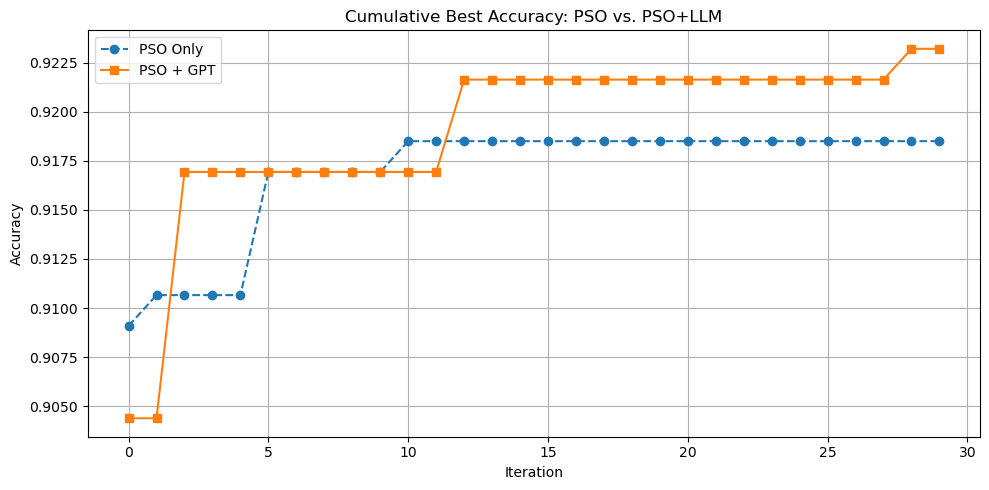

In [19]:
# Section 6: Visualization
plt.figure(figsize=(10, 5))
plt.plot(best_so_far_history, label="PSO Only", linestyle='--', marker='o')
plt.plot(llm_best_so_far_history, label="PSO + GPT", marker='s')
plt.title("Cumulative Best Accuracy: PSO vs. PSO+LLM")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
